# Mini Project 2 - Code

In [1]:
# Import cells
import context
from miniproj_2_fncs import Integrator
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

******************************
context imported. Front of path:
C:\Users\13432\Documents\ATSC_409
back of path: C:\Users\13432\miniconda3\envs\numeric_2024\Lib\site-packages\Pythonwin
******************************

through C:\Users\13432\Documents\ATSC_409\numeric_2024\mini-projects\context.py


## 1. We first need to make some changes to the yaml file to adapt it to our project.

The changes made to the yaml file are to:

- Inlcude initial fractions for the rabbits and the foxes in the initial conditions
- Add birth rates and death rates for both the rabbits and for the foxes in the uservars
- Add consumption rates for the daisies and the rabbits in th uservars

## 2. Modify the integrator class to be used for this project

This can be done by making small modifications when the yaml file is read in and creates the object. In addition, the only other place where we need to make changes is within the derivs5 function as all our parameters are being passed into that, so we can add our other differential equations there as well.

In [2]:
class Integ54(Integrator):
    def set_yinit(self):
        #
        # read in 'albedo_white chi S0 L albedo_black R albedo_ground rabbit_birth rabbit_death fox_birth fox_death daisy_rate rabbit_rate'
        #
        # *********** NOTE: Our changes in the yaml file are now being read into uservars
        uservars = namedtuple('uservars', self.config['uservars'].keys())
        self.uservars = uservars(**self.config['uservars'])
        #
        # read in 'whiteconc blackconc rabbitconc foxconc'
        #
        # *********** NOTE: Our changes in the initial conditions are now being passed into yinit
        initvars = namedtuple('initvars', self.config['initvars'].keys())
        self.initvars = initvars(**self.config['initvars'])
        self.yinit = np.array(
            [self.initvars.whiteconc, self.initvars.blackconc, self.initvars.rabbitconc, self.initvars.foxconc]) # added the initial conditions for foxes and rabbits to be read in
        self.nvars = len(self.yinit)
        return None

    def __init__(self, coeff_file_name):
        super().__init__(coeff_file_name)
        self.set_yinit()

    def find_temp(self, yvals):
        """
            Calculate the temperatures over the white and black daisies
            and the planetary equilibrium temperature given the daisy fractions

            input:  yvals -- array of dimension [2] with the white [0] and black [1]
                    daisy fractiion
            output:  white temperature (K), black temperature (K), equilibrium temperature (K)
        """
        sigma = 5.67e-8  # Stefan Boltzman constant W/m^2/K^4
        user = self.uservars
        bare = 1.0 - yvals[0] - yvals[1]
        albedo_p = bare * user.albedo_ground + \
            yvals[0] * user.albedo_white + yvals[1] * user.albedo_black
        Te_4 = user.S0 / 4.0 * user.L * (1.0 - albedo_p) / sigma
        temp_e = Te_4**0.25
        eta = user.R * user.L * user.S0 / (4.0 * sigma)
        temp_b = (eta * (albedo_p - user.albedo_black) + Te_4)**0.25
        temp_w = (eta * (albedo_p - user.albedo_white) + Te_4)**0.25
        return (temp_w, temp_b, temp_e)

    def derivs5(self, y, t):
        """y[0]=fraction white daisies
           y[1]=fraction black daisies
           y[2]=fraction rabbits
           y[3]=fraction foxes
           no feedback between daisies and
           albedo_p (set to ground albedo)
        """
        temp_w, temp_b, temp_e = self.find_temp(y)

        if (temp_b >= 277.5 and temp_b <= 312.5):
            beta_b = 1.0 - 0.003265 * (295.0 - temp_b)**2.0
        else:
            beta_b = 0.0

        if (temp_w >= 277.5 and temp_w <= 312.5):
            beta_w = 1.0 - 0.003265 * (295.0 - temp_w)**2.0
        else:
            beta_w = 0.0
        user = self.uservars
        bare = 1.0 - y[0] - y[1]
        # create a 1 x 2 element vector to hold the derivitive
        f = np.empty_like(y)

        ######## Most changes made are below ########
        
        f[0] = y[0] * (beta_w * bare - user.chi - user.daisy_rate*y[2]) # Just added the daisy consumption from the rabbits
        f[1] = y[1] * (beta_b * bare - user.chi - user.daisy_rate*y[2]) # Just added the daisy consumption from the rabbits
        f[2] = y[2] * (user.rabbit_birth*(1-bare) - user.rabbit_death - user.rabbit_rate*y[3]) # Added our differential equation for the rabbit population  
        f[3] = y[3]*(user.fox_birth*y[2] - user.fox_death) # Added differential equation for the fox population

        ## NOTE: could potentially add logic if population fraction is less than or equal to 0.01 and actually just set it to zero. Mentioned in discussion section.
        ## Could also add a population cap for rabbits and for foxes.
        
        return f

## Run the simulation and plot the results
Use the code from the lab, excpet we add the rabbits and foxes into the dictionary and plot those as well.

(0.0, 0.8)

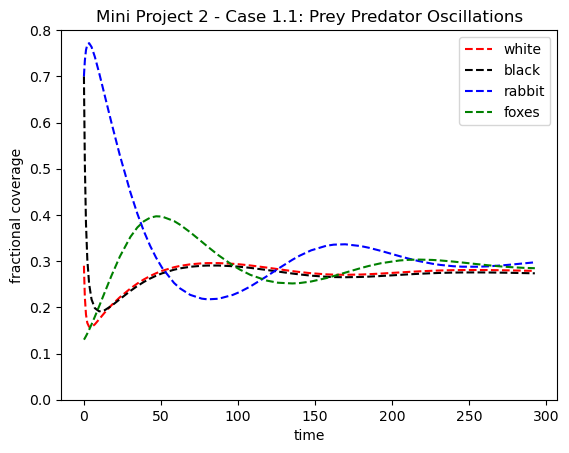

In [3]:
theSolver = Integ54('rabbits_and_foxes.yaml')
timevals, yvals, errorlist = theSolver.timeloop5Err()
daisies = pd.DataFrame(yvals, columns=['white', 'black', 'rabbits', 'foxes'])

thefig, theAx = plt.subplots(1, 1)
line1, = theAx.plot(timevals, daisies['white'])
line2, = theAx.plot(timevals, daisies['black'])
line3, = theAx.plot(timevals, daisies['rabbits'])
line4, = theAx.plot(timevals, daisies['foxes'])
line1.set(linestyle='--', color='r', label='white')
line2.set(linestyle='--', color='k', label='black')
line3.set(linestyle='--', color='b', label='rabbit')
line4.set(linestyle='--', color='g', label='foxes')
theAx.set_title('Mini Project 2 - Case 1.1: Prey Predator Oscillations')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='upper right')
theAx.set_ylim(0,0.8)

(0.0, 0.8)

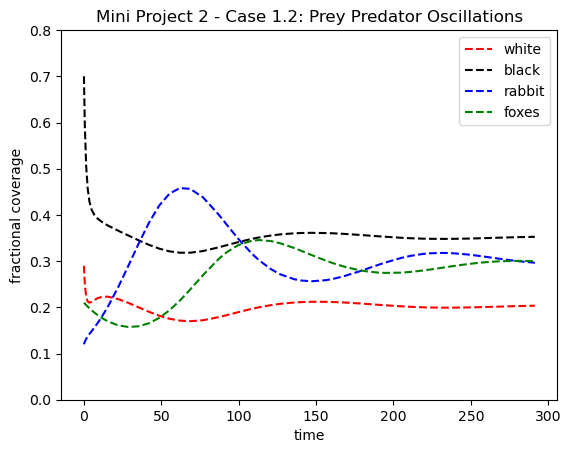

In [4]:
theSolver = Integ54('rabbits_and_foxes2.yaml')
timevals, yvals, errorlist = theSolver.timeloop5Err()
daisies = pd.DataFrame(yvals, columns=['white', 'black', 'rabbits', 'foxes'])

thefig, theAx = plt.subplots(1, 1)
line1, = theAx.plot(timevals, daisies['white'])
line2, = theAx.plot(timevals, daisies['black'])
line3, = theAx.plot(timevals, daisies['rabbits'])
line4, = theAx.plot(timevals, daisies['foxes'])
line1.set(linestyle='--', color='r', label='white')
line2.set(linestyle='--', color='k', label='black')
line3.set(linestyle='--', color='b', label='rabbit')
line4.set(linestyle='--', color='g', label='foxes')
theAx.set_title('Mini Project 2 - Case 1.2: Prey Predator Oscillations')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='upper right')
theAx.set_ylim(0,0.8)

(0.0, 0.84)

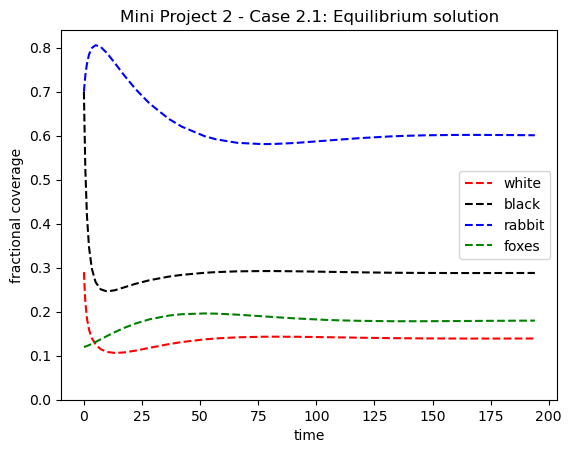

In [5]:
theSolver = Integ54('rabbits_and_foxes3.yaml')
timevals, yvals, errorlist = theSolver.timeloop5Err()
daisies = pd.DataFrame(yvals, columns=['white', 'black', 'rabbits', 'foxes'])

thefig, theAx = plt.subplots(1, 1)
line1, = theAx.plot(timevals, daisies['white'])
line2, = theAx.plot(timevals, daisies['black'])
line3, = theAx.plot(timevals, daisies['rabbits'])
line4, = theAx.plot(timevals, daisies['foxes'])
line1.set(linestyle='--', color='r', label='white')
line2.set(linestyle='--', color='k', label='black')
line3.set(linestyle='--', color='b', label='rabbit')
line4.set(linestyle='--', color='g', label='foxes')
theAx.set_title('Mini Project 2 - Case 2.1: Equilibrium solution')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='center right')
theAx.set_ylim(0,0.84)

(0.0, 0.84)

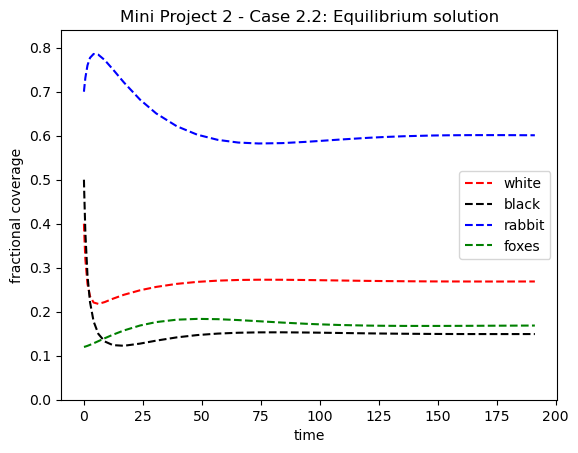

In [6]:
theSolver = Integ54('rabbits_and_foxes4.yaml')
timevals, yvals, errorlist = theSolver.timeloop5Err()
daisies = pd.DataFrame(yvals, columns=['white', 'black', 'rabbits', 'foxes'])

thefig, theAx = plt.subplots(1, 1)
line1, = theAx.plot(timevals, daisies['white'])
line2, = theAx.plot(timevals, daisies['black'])
line3, = theAx.plot(timevals, daisies['rabbits'])
line4, = theAx.plot(timevals, daisies['foxes'])
line1.set(linestyle='--', color='r', label='white')
line2.set(linestyle='--', color='k', label='black')
line3.set(linestyle='--', color='b', label='rabbit')
line4.set(linestyle='--', color='g', label='foxes')
theAx.set_title('Mini Project 2 - Case 2.2: Equilibrium solution')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='center right')
theAx.set_ylim(0,0.84)

(0.0, 0.84)

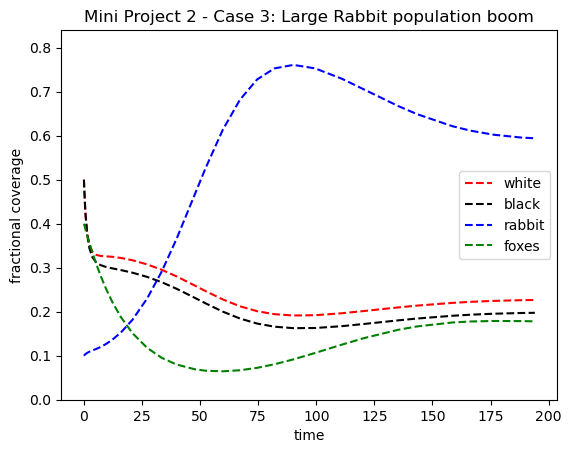

In [4]:
theSolver = Integ54('rabbits_and_foxes5.yaml')
timevals, yvals, errorlist = theSolver.timeloop5Err()
daisies = pd.DataFrame(yvals, columns=['white', 'black', 'rabbits', 'foxes'])

thefig, theAx = plt.subplots(1, 1)
line1, = theAx.plot(timevals, daisies['white'])
line2, = theAx.plot(timevals, daisies['black'])
line3, = theAx.plot(timevals, daisies['rabbits'])
line4, = theAx.plot(timevals, daisies['foxes'])
line1.set(linestyle='--', color='r', label='white')
line2.set(linestyle='--', color='k', label='black')
line3.set(linestyle='--', color='b', label='rabbit')
line4.set(linestyle='--', color='g', label='foxes')
theAx.set_title('Mini Project 2 - Case 3: Large Rabbit population boom')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='center right')
theAx.set_ylim(0,0.84)

(0.0, 1.0)

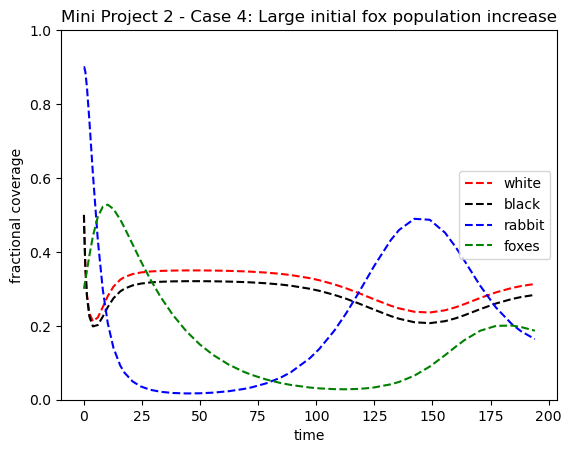

In [5]:
theSolver = Integ54('rabbits_and_foxes6.yaml')
timevals, yvals, errorlist = theSolver.timeloop5Err()
daisies = pd.DataFrame(yvals, columns=['white', 'black', 'rabbits', 'foxes'])

thefig, theAx = plt.subplots(1, 1)
line1, = theAx.plot(timevals, daisies['white'])
line2, = theAx.plot(timevals, daisies['black'])
line3, = theAx.plot(timevals, daisies['rabbits'])
line4, = theAx.plot(timevals, daisies['foxes'])
line1.set(linestyle='--', color='r', label='white')
line2.set(linestyle='--', color='k', label='black')
line3.set(linestyle='--', color='b', label='rabbit')
line4.set(linestyle='--', color='g', label='foxes')
theAx.set_title('Mini Project 2 - Case 4: Large initial fox population increase')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='center right')
theAx.set_ylim(0,1)

(0.0, 1.0)

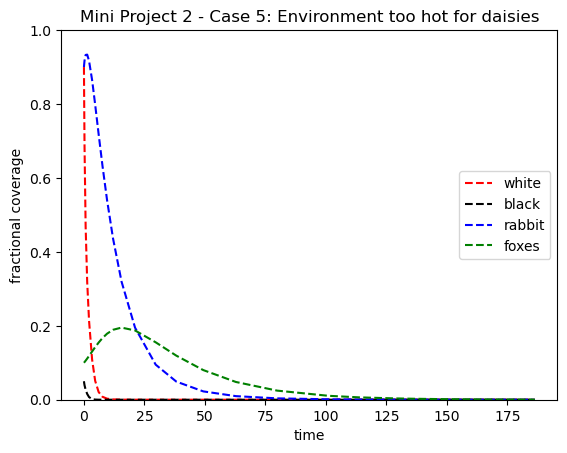

In [6]:
theSolver = Integ54('rabbits_and_foxes7.yaml')
timevals, yvals, errorlist = theSolver.timeloop5Err()
daisies = pd.DataFrame(yvals, columns=['white', 'black', 'rabbits', 'foxes'])

thefig, theAx = plt.subplots(1, 1)
line1, = theAx.plot(timevals, daisies['white'])
line2, = theAx.plot(timevals, daisies['black'])
line3, = theAx.plot(timevals, daisies['rabbits'])
line4, = theAx.plot(timevals, daisies['foxes'])
line1.set(linestyle='--', color='r', label='white')
line2.set(linestyle='--', color='k', label='black')
line3.set(linestyle='--', color='b', label='rabbit')
line4.set(linestyle='--', color='g', label='foxes')
theAx.set_title('Mini Project 2 - Case 5: Environment too hot for daisies')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='center right')
theAx.set_ylim(0,1)

(0.0, 1.0)

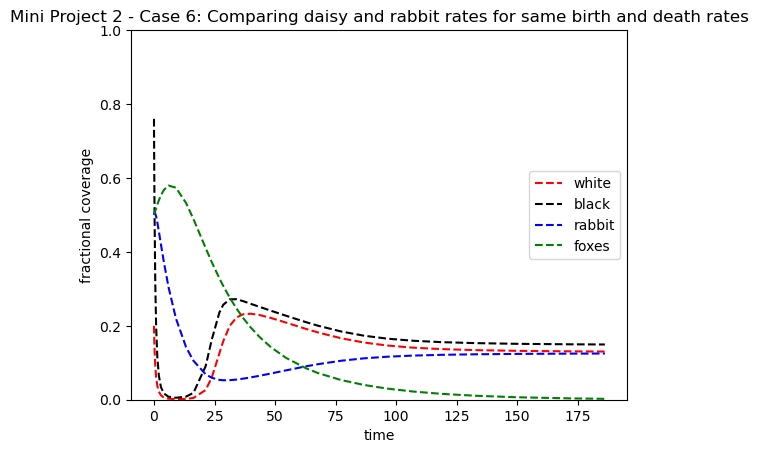

In [26]:
theSolver = Integ54('rabbits_and_foxes8.yaml')
timevals, yvals, errorlist = theSolver.timeloop5Err()
daisies = pd.DataFrame(yvals, columns=['white', 'black', 'rabbits', 'foxes'])

thefig, theAx = plt.subplots(1, 1)
line1, = theAx.plot(timevals, daisies['white'])
line2, = theAx.plot(timevals, daisies['black'])
line3, = theAx.plot(timevals, daisies['rabbits'])
line4, = theAx.plot(timevals, daisies['foxes'])
line1.set(linestyle='--', color='r', label='white')
line2.set(linestyle='--', color='k', label='black')
line3.set(linestyle='--', color='b', label='rabbit')
line4.set(linestyle='--', color='g', label='foxes')
theAx.set_title('Mini Project 2 - Case 6: Comparing daisy and rabbit rates for same birth and death rates')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='center right')
theAx.set_ylim(0,1)

(0.0, 1.0)

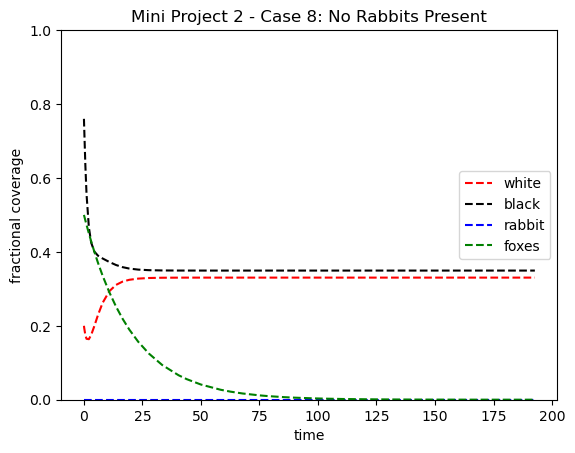

In [21]:
theSolver = Integ54('rabbits_and_foxes9.yaml')
timevals, yvals, errorlist = theSolver.timeloop5Err()
daisies = pd.DataFrame(yvals, columns=['white', 'black', 'rabbits', 'foxes'])

thefig, theAx = plt.subplots(1, 1)
line1, = theAx.plot(timevals, daisies['white'])
line2, = theAx.plot(timevals, daisies['black'])
line3, = theAx.plot(timevals, daisies['rabbits'])
line4, = theAx.plot(timevals, daisies['foxes'])
line1.set(linestyle='--', color='r', label='white')
line2.set(linestyle='--', color='k', label='black')
line3.set(linestyle='--', color='b', label='rabbit')
line4.set(linestyle='--', color='g', label='foxes')
theAx.set_title('Mini Project 2 - Case 8: No Rabbits Present')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='center right')
theAx.set_ylim(0,1)